## Surface Interpolation

This notebook walks through the different steps needed to obtain the surface-interpolated precipitation values over each individual catchment, for the higher resolution data downloaded from Era5-land (see assembly.py). 

In [47]:
import paths
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import matplotlib.ticker as mtk

from tqdm import tqdm
from train_model import load_data
from preprocessing import visualisation
from preprocessing import surface_interpolation as si
from preprocessing import catchment_characteristics as cc

### 1. Input Parameters

Define the number (gauge station) of the catchment we want to interpolate over. Based on this catchment number we retrieve the catchment boundary (as a shapefile), from the larger 'Catchment_Fens.csv'. This csv-file is constructed based on the information available from the NRFA website.

Additionally, we open the dataset containing the rainfall information over the UK (9h till 9h per day) from 1979 till 2021. 

Lastly, we define the grid resolution at which the data will be interpolated (integrated). 

In [48]:
station_nr = 54057

database = pd.read_csv('../' + paths.DATA + '/Catchments_Database.csv').rename(columns={'Station number': 'Station_number'})

station_db = database.query(f"Station_number == {station_nr}")
catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))

domain_rain = xr.open_dataset('../' + paths.RAINFALL_UK_SHIFTED_HR, engine='netcdf4')
                              
DATA_RESOLUTION = 0.10
INTEGRATION_RESOLUTION = 0.05

### 2. Raster Extraction

We extract the raster over which we will fit the interpolation curves (to avoid fitting curves over the full territory of the UK). We can visualize this raster on a map of the UK, displaying the precipitation intensity per grid square for a specific day (here by default 1st of January 1981).

In [50]:
bbox = si.extract_raster_to_interpolate(catchment_boundary, DATA_RESOLUTION, buffer=2)

visualisation.plot_spatial_distribution(domain_data=domain_rain, 
                                        catchment_polygon=catchment_boundary, 
                                        date=(1981,1,1), 
                                        value_column='tp', 
                                        bbox=bbox, 
                                        crop=True, 
                                        resolution=DATA_RESOLUTION)

### 3. Grid Interpolation

Based on the cropped grid, we fit a set of functions to the data (1 for each timestep, corresponding to 1 day, in the dataset). Visualization of the first few functions shows how the precipitation intensity varies over time.

In [54]:
import importlib
importlib.reload(si)

<module 'preprocessing.surface_interpolation' from 'C:\\Users\\aline\\soil-moisture-proxies\\preprocessing\\surface_interpolation.py'>

100%|██████████| 15340/15340 [01:54<00:00, 133.44it/s]


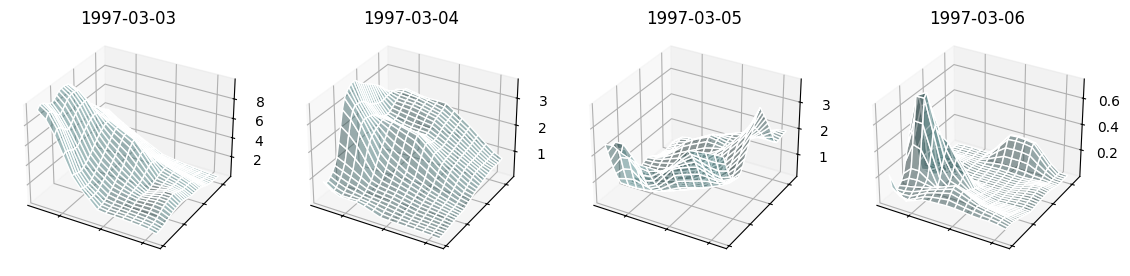

CPU times: total: 18.8 s
Wall time: 2min


In [53]:
%%time
    
lat_min, lat_max, lon_min, lon_max = si.extract_raster_to_interpolate(catchment_boundary, DATA_RESOLUTION)
#domain_rain = domain_rain.sortby('latitude', ascending=True)
subset = domain_rain.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
subset = subset.where(~((subset['time'].dt.year == 1979)), drop=True)

save_path = f"{paths.IMAGES}/interpolation_precipitation_HR.png"
interpolated_functions = si.interpolate_surface(subset, plot=True, save_path=save_path, plot_date='1997-03-03')

### 4. Integration over the Catchment Surface

The surface interpolation only applies to the precipitation and thus, for all other parameters, we recuperate the linearly interpolated values from before.

To integrate over a surface with an irregular shape, we define a grid of points (with a predefined resolution) around the catchment polygon. We evaluate the points that lie within the polygon through the previously defined interpolated functions, for each timestep. Dividing the sum of these values by the number of points within the polygon gives the final precipitation value for the catchment.

Additionally, we recalculate the shifted rain values (28 per day) and proxies (30, 60, 90 days rolling mean) from the newly obtained precipitation values. 

In [55]:
rain_columns = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(27)])
rf_test = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_linear.csv'), verbose=False)
rf_test = rf_test.drop(columns=rain_columns)

In [56]:
%%time
tqdm.pandas()
#rf_test = rf_test[:365]
rf_test['Rain'] = rf_test['Date'].progress_apply(
    lambda time: si.integrate_rainfall_safe(np.datetime64(time, 'ns'), catchment_boundary, interpolated_functions, grid_resolution=0.05)
).astype('float64')
rf_test

  1%|          | 174/15374 [00:02<04:16, 59.24it/s] 


KeyboardInterrupt: 

In [57]:
si.plot_integration(catchment_boundary, grid_resolution=0.05)

#### 4. Compare Era5 (0.25 x 0.25) and Era5-land (0.1 x 0.1) surface interpolated precipitation values

The following plot compares the precipitation values as obtained with the surface interpolation method for both Era5 (see notebook 'Surface interpolation.ipynb' and Era5-land (higher resolution) data.

In [61]:
importlib.reload(visualisation)

<module 'preprocessing.visualisation' from 'C:\\Users\\aline\\soil-moisture-proxies\\preprocessing\\visualisation.py'>

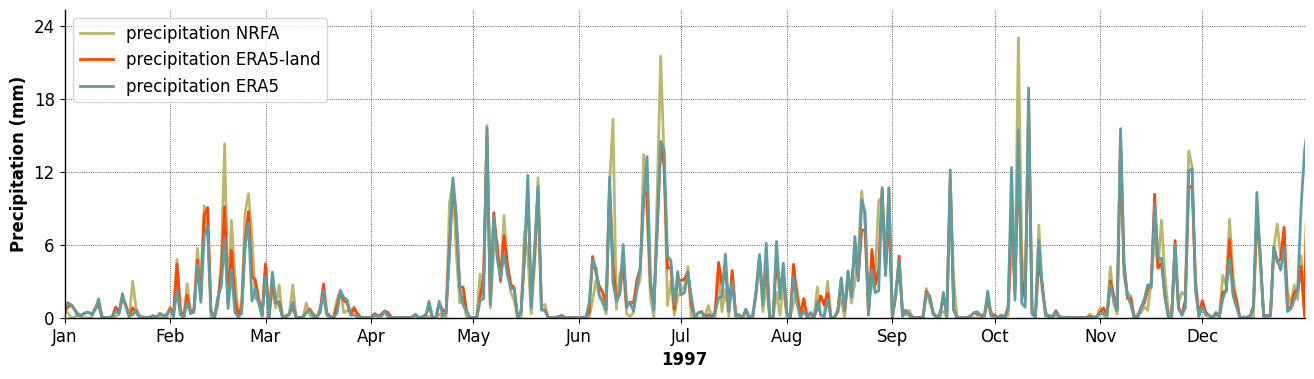

In [64]:
station_nr = 54057

rf_interp_HR = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_HR_surf_interp.csv'), verbose=False)
rf_interp =load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_HR_linear.csv'), verbose=False)
rf_nrfa =load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False).dropna()

rf_interp_HR['Date'] = pd.to_datetime(rf_interp_HR['Date'], format='%Y-%m-%d')
rf_interp['Date'] = pd.to_datetime(rf_interp['Date'], format='%Y-%m-%d')
rf_nrfa['Date'] = pd.to_datetime(rf_nrfa['Date'], format='%Y-%m-%d')

visualisation.compare_precipitation_and_flow(year = 1997,
                                             dfs_precipitation=[rf_nrfa, rf_interp_HR, rf_interp], 
                                             colors=['darkKhaki', 'orangered', 'cadetblue'],
                                             labels=['NRFA',
                                                     'ERA5-land', 
                                                     'ERA5'], 
                                             save_path=f"{paths.IMAGES}/Era5_vs_Era5-land.png",
                                             figsize=(16,4))

#### 5. Compare Model performance Era5 versus Era5-land

The following plot compares the model performance of Era5 and Era5-land (both with snow melt included), and surface interpolated

In [65]:
overview_HR_surface_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_HR_linear_Snow')
overview_surface_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_linear_Snow')
overview_nrfa_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_nrfa_Snow')

comparison = overview_surface_snow_gdf.merge(overview_nrfa_snow_gdf[['Station', 'NSE']], on='Station')
comparison = comparison.rename(columns={'NSE_x':'NSE_Era5', 'NSE_y':'NSE_NRFA'})

comparison = overview_HR_surface_snow_gdf.merge(comparison[['Station', 'NSE_Era5', 'NSE_NRFA']], on='Station')

#comparison[['Station', 'NSE_linear', 'NSE_surface_interpolated']]

C:\Users\aline\AppData\Local\Temp\ipykernel_360\921753821.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(latitude_labels, rotation=45, fontsize=12)


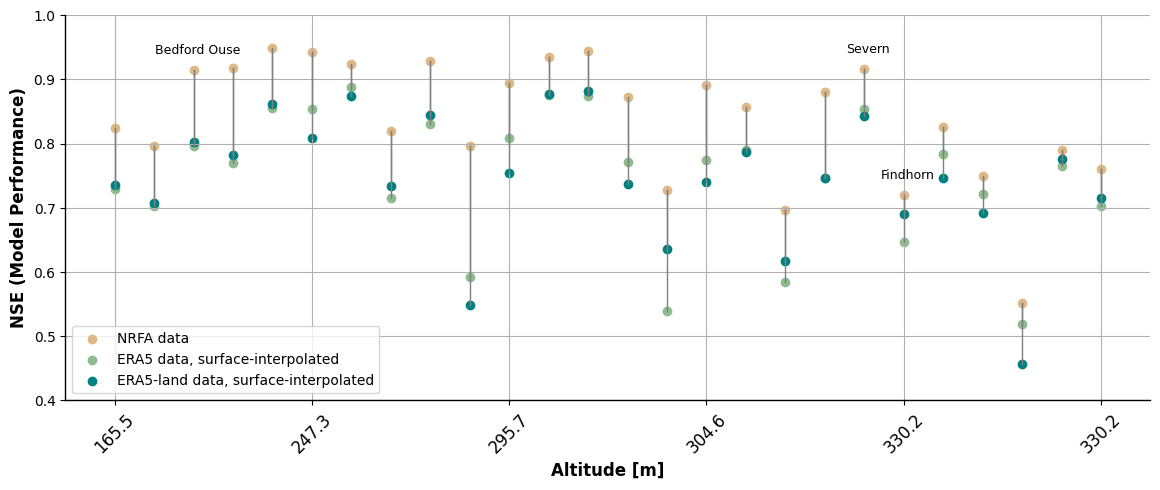

In [69]:
catchment_dict ={'7001':'Findhorn',
                 '33039':'Bedford Ouse',
                 '54057':'Severn'}

# Sort Dataframe by altitude
comparison = comparison.sort_values(by='Maximum altitude').reset_index(drop=True)
latitude_labels = [round(value, 2) for value in comparison['Maximum altitude']]

fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot NSE values for Era5 and NRFA as dots
ax1.scatter(comparison.index, comparison['NSE_NRFA'], color='BurlyWood', label='NRFA data')
ax1.scatter(comparison.index, comparison['NSE_Era5'], color='darkseagreen', label='ERA5 data, surface-interpolated')
ax1.scatter(comparison.index, comparison['NSE'], color='Teal', label='ERA5-land data, surface-interpolated')

# Draw lines between each pair of dots
for i in range(len(comparison)):
    ax1.plot([i, i], [comparison['NSE_NRFA'].iloc[i], comparison['NSE_Era5'].iloc[i]], color='gray', linestyle='-', linewidth=1)
    ax1.plot([i, i], [comparison['NSE_NRFA'].iloc[i], comparison['NSE'].iloc[i]], color='gray', linestyle='-', linewidth=1)
    
# Add station names next to the focus catchments
param = 'NSE_NRFA'
for j, row in comparison.iterrows():
    if row['Station'] in ['7001','33039','54057']:
        x_offset = 0.1
        y_offset = 0.025
        ax1.text(j + x_offset, row[param] + y_offset, catchment_dict.get(row['Station']), fontsize=9, ha='center')

# Labels and title for the first axis
ax1.set_xlabel('Altitude [m]', fontweight='bold', fontsize=12)
ax1.set_ylabel('NSE')
ax1.set_xticklabels(latitude_labels, rotation=45, fontsize=12)
ax1.set_ylim(0.4,1)
ax1.set_ylabel('NSE (Model Performance)', fontweight='bold', fontsize=12)
ax1.legend(loc='lower left')

ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')

plt.grid(True)
plt.savefig(f"{paths.IMAGES}/Era5_vs_Era5-land_performance.png", dpi=300, bbox_inches='tight')
plt.show()